
# Comparison between grid search and successive halving

This example compares the parameter search performed by
:class:`~sklearn.model_selection.HalvingGridSearchCV` and
:class:`~sklearn.model_selection.GridSearchCV`.

In [1]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.svm import SVC
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

We first define the parameter space for an :class:`~sklearn.svm.SVC`
estimator, and compute the time required to train a
:class:`~sklearn.model_selection.HalvingGridSearchCV` instance, as well as a
:class:`~sklearn.model_selection.GridSearchCV` instance.

In [2]:
rng = np.random.RandomState(0)
X, y = datasets.make_classification(n_samples=1000, random_state=rng)

gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
Cs = [1, 10, 100, 1e3, 1e4, 1e5]
param_grid = {"gamma": gammas, "C": Cs}

clf = SVC(random_state=rng)

tic = time()
gsh = HalvingGridSearchCV(
    estimator=clf, param_grid=param_grid, factor=2, random_state=rng
)
gsh.fit(X, y)
gsh_time = time() - tic

tic = time()
gs = GridSearchCV(estimator=clf, param_grid=param_grid)
gs.fit(X, y)
gs_time = time() - tic

We now plot heatmaps for both search estimators.

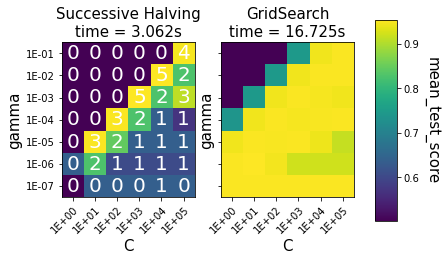

In [3]:
def make_heatmap(ax, gs, is_sh=False, make_cbar=False):
    """Helper to make a heatmap."""
    results = pd.DataFrame(gs.cv_results_)
    results[["param_C", "param_gamma"]] = results[["param_C", "param_gamma"]].astype(
        np.float64
    )
    if is_sh:
        # SH dataframe: get mean_test_score values for the highest iter
        scores_matrix = results.sort_values("iter").pivot_table(
            index="param_gamma",
            columns="param_C",
            values="mean_test_score",
            aggfunc="last",
        )
    else:
        scores_matrix = results.pivot(
            index="param_gamma", columns="param_C", values="mean_test_score"
        )

    im = ax.imshow(scores_matrix)

    ax.set_xticks(np.arange(len(Cs)))
    ax.set_xticklabels(["{:.0E}".format(x) for x in Cs])
    ax.set_xlabel("C", fontsize=15)

    ax.set_yticks(np.arange(len(gammas)))
    ax.set_yticklabels(["{:.0E}".format(x) for x in gammas])
    ax.set_ylabel("gamma", fontsize=15)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    if is_sh:
        iterations = results.pivot_table(
            index="param_gamma", columns="param_C", values="iter", aggfunc="max"
        ).values
        for i in range(len(gammas)):
            for j in range(len(Cs)):
                ax.text(
                    j,
                    i,
                    iterations[i, j],
                    ha="center",
                    va="center",
                    color="w",
                    fontsize=20,
                )

    if make_cbar:
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        cbar_ax.set_ylabel("mean_test_score", rotation=-90, va="bottom", fontsize=15)


fig, axes = plt.subplots(ncols=2, sharey=True)
ax1, ax2 = axes

make_heatmap(ax1, gsh, is_sh=True)
make_heatmap(ax2, gs, make_cbar=True)

ax1.set_title("Successive Halving\ntime = {:.3f}s".format(gsh_time), fontsize=15)
ax2.set_title("GridSearch\ntime = {:.3f}s".format(gs_time), fontsize=15)

plt.show()

The heatmaps show the mean test score of the parameter combinations for an
:class:`~sklearn.svm.SVC` instance. The
:class:`~sklearn.model_selection.HalvingGridSearchCV` also shows the
iteration at which the combinations where last used. The combinations marked
as ``0`` were only evaluated at the first iteration, while the ones with
``5`` are the parameter combinations that are considered the best ones.

We can see that the :class:`~sklearn.model_selection.HalvingGridSearchCV`
class is able to find parameter combinations that are just as accurate as
:class:`~sklearn.model_selection.GridSearchCV`, in much less time.

Los mapas de calor muestran la puntuación media de la prueba de las combinaciones de parámetros para una instancia de :class:~sklearn.svm.SVC. El :class:~sklearn.model_selection.HalvingGridSearchCV también muestra la iteración en la que se usaron las combinaciones por última vez. Las combinaciones marcadas con 0 solo fueron evaluadas en la primera iteración, mientras que las que tienen 5 son las combinaciones de parámetros que se consideran las mejores.

Podemos ver que la clase :class:~sklearn.model_selection.HalvingGridSearchCV es capaz de encontrar combinaciones de parámetros que son tan precisas como :class:~sklearn.model_selection.GridSearchCV, en mucho menos tiempo.

#Probar con los datos del censo

Lo primero es limpiar todas las columnas

In [4]:
adult_census = pd.read_csv("https://github.com/INRIA/scikit-learn-mooc/blob/main/datasets/adult-census.csv?raw=true")
obj_cols = adult_census.select_dtypes(include="object").columns
for col in obj_cols:
  adult_census[col] = pd.Categorical(adult_census[col])

cat_cols = adult_census.select_dtypes(include="category").columns
for col in cat_cols:
  adult_census[col] = adult_census[col].cat.codes


In [5]:
adult_census

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,4,1,7,4,7,3,2,1,0,0,40,39,0
1,38,4,11,9,2,5,0,4,1,0,0,50,39,0
2,28,2,7,12,2,11,0,4,1,0,0,40,39,1
3,44,4,15,10,2,7,0,2,1,7688,0,40,39,1
4,18,0,15,10,4,0,3,4,0,0,0,30,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,4,7,12,2,13,5,4,0,0,0,38,39,0
48838,40,4,11,9,2,7,0,4,1,0,0,40,39,1
48839,58,4,11,9,6,1,4,4,0,0,0,40,39,0
48840,22,4,11,9,4,1,3,4,1,0,0,20,39,0


Aquí he tenido que quitar las columnas que parecen menos relevantes y recortar las filas del dataframe de a 1000 para aligerar el proceso más adelante ya que tardaba demasiados minutos

In [6]:
Y = adult_census["class"]
Y=Y[:1000]

X = adult_census.drop(columns=["class","marital-status","relationship", "hours-per-week","sex", "age","capital-loss", "native-country","education-num"])
X=X[:1000]

Normalizar los campos para obtener un resultado más preciso

In [7]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X1=scaler.fit_transform(X)


Comprobar los tiempos del gridsearch normal y el gridsearch con halving

In [8]:
modelo_censo=SVC(random_state=0)
censo_halvingcv = HalvingGridSearchCV(estimator=modelo_censo, param_grid=param_grid, factor=2, random_state=0)
censo_cv = GridSearchCV(estimator=modelo_censo, param_grid=param_grid)

tic = time()
censo_halvingcv.fit(X1,Y)

censoH_time = time() - tic
print(censoH_time)
tic = time()

censo_cv.fit(X1,Y)
censo_time = time() - tic
print(censo_time)


6.770756006240845
339.3067708015442


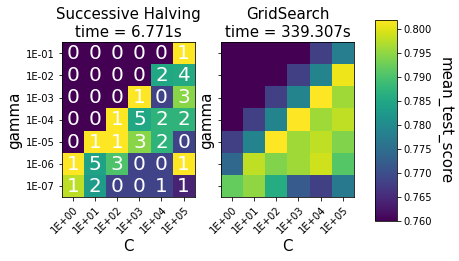

In [9]:
fig, axes = plt.subplots(ncols=2, sharey=True)
ax1, ax2 = axes

make_heatmap(ax1, censo_halvingcv, is_sh=True)
make_heatmap(ax2, censo_cv, make_cbar=True)

ax1.set_title("Successive Halving\ntime = {:.3f}s".format(censoH_time), fontsize=15)
ax2.set_title("GridSearch\ntime = {:.3f}s".format(censo_time), fontsize=15)

plt.show()

Como se puede apreciar, en los mapas de calor los resultados son bastante parecidos, aunque algo más distintos que los del ejemplo de arriba.




Donde la diferencia es mucho mayor, es en el tiempo de procesado.
En el ejemplo el Grid Search con Halving es unas 6 veces más rapido, mientras que con el conjunto de datos con etiquetas "adult_census", el Grid Search con Halving es unas **38** veces más rapido, por lo que es incluso más deseable usarlo en un caso real.